In [1]:
from copy import deepcopy

import pandas as pd
import torch.nn as nn
import torch

import nlopt
from numpy import *
import numpy as np

torch.set_default_dtype(torch.float64)
np.set_printoptions(precision=32)

!pip install --upgrade "jax[cpu]"

import jax
import jax.numpy as jnp
from jax import nn as jax_nn
from jax.config import config; config.update("jax_enable_x64", True)
jnp.set_printoptions(precision=32) 
from jax import jacfwd, jacrev
from jax import grad as jax_grad

import matplotlib.pyplot as plt

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: jax[cpu] in ./.local/lib/python3.6/site-packages (0.2.17)


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
N, D_in, H_student, D_out = 1, 10, 10, 1

In [4]:
data = pd.read_csv('mnist/train_10pca.csv', float_precision='round_trip')
data.head()

,Unnamed: 0,1_principal,2_principal,3_principal,4_principal,5_principal,6_principal,7_principal,8_principal,9_principal,10_principal,label
0,0,-5.140478,-5.226451,3.886993,-0.901512,4.929209,2.036187,4.706960,-4.764459,0.238225,-1.459020,1.0
1,1,19.292333,6.033014,1.308196,-2.383076,3.095021,-1.794193,-3.770784,0.148453,-4.154969,-4.295380,-1.0
2,2,-7.644504,-1.705801,2.289336,2.241256,5.094750,-4.152694,-1.011677,1.733929,0.422061,-0.072606,1.0
3,3,-0.474206,5.836146,2.008588,4.271250,2.378019,2.179969,4.397159,-0.346711,1.018367,5.470587,-1.0
4,4,26.559575,6.024832,0.933257,-3.012613,9.488500,-2.333748,-6.146737,-1.796978,-4.180035,-5.717939,-1.0


In [5]:
## A customizable student network, initialized using Glorot initialization.
class StudentNetwork(nn.Module):
  def __init__(self, D_in, H, D_out):
    """
    In the constructor we instantiate two nn.Linear modules and assign them as
    member variables.

    D_in: input dimension
    H: dimension of hidden layer
    D_out: output dimension of the first layer
    """
    super(StudentNetwork, self).__init__()
    self.linear1 = nn.Linear(D_in, H, bias=True).double()
    self.linear2 = nn.Linear(H, H, bias=True).double()
    self.linear3 = nn.Linear(H, H, bias=True).double()
    self.linear4 = nn.Linear(H, D_out, bias=True).double()

    nn.init.xavier_uniform_(self.linear1.weight)
    nn.init.xavier_uniform_(self.linear2.weight)
    nn.init.xavier_uniform_(self.linear3.weight)
    nn.init.xavier_uniform_(self.linear4.weight)
    
    nn.init.constant_(self.linear1.bias, 0)
    nn.init.constant_(self.linear2.bias, 0)
    nn.init.constant_(self.linear3.bias, 0)
    nn.init.constant_(self.linear4.bias, 0)

  def forward(self, x):
    h1 = torch.sigmoid(self.linear1(x))
    h2 = torch.sigmoid(self.linear2(h1))
    h3 = torch.sigmoid(self.linear3(h2))
    y_pred = self.linear4(h3)
    return h2, y_pred

In [6]:
dataset_inputs = []
dataset_labels = []

for idx, row in data.iterrows():
    pca_components = []
    for idx_pca_component in range(1, 11):
        pca_components.append(row[str(idx_pca_component) + '_principal'])
    dataset_inputs.append(pca_components)
    dataset_labels.append(row['label'])

In [7]:
torch_dataset_inputs = torch.DoubleTensor(dataset_inputs[:10000]).to(device)
torch_dataset_labels = torch.DoubleTensor([dataset_labels[:10000]]).T.to(device)

In [8]:
jnp_dataset_inputs = jnp.array(dataset_inputs[:10000], dtype=jnp.float64)
jnp_dataset_labels = jnp.array(dataset_labels[:10000], dtype=jnp.float64)

In [9]:
student_model = StudentNetwork(D_in, H_student, D_out)
student_model = student_model.to(device)
if device == 'cuda':
    student_model = torch.nn.DataParallel(student_model)

checkpoint = torch.load("model_1e-6.pt")
student_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [10]:
_, y = student_model(torch_dataset_inputs)
loss = nn.MSELoss()(y, torch_dataset_labels)

In [11]:
print(loss.item())

0.10269205534607684


In [12]:
loss_grad = torch.autograd.grad(loss, student_model.parameters(),
                                      retain_graph=True)

In [13]:
def eval_grad_norm(loss_grad):
  cnt = 0
  for g in loss_grad:
      if cnt == 0:
        g_vector = g.contiguous().view(-1)
      else:
        g_vector = torch.cat([g_vector, g.contiguous().view(-1)])
      cnt = 1
  grad_norm = torch.norm(g_vector)
 
  return grad_norm.cpu().detach().numpy()

print(eval_grad_norm(loss_grad))

9.950165295930524e-06


In [14]:
trace = []
trace.append((deepcopy(student_model.module.linear1.weight.cpu().data.detach().numpy()),
              deepcopy(student_model.module.linear1.bias.cpu().data.detach().numpy()),
              deepcopy(student_model.module.linear2.weight.cpu().data.detach().numpy()),
              deepcopy(student_model.module.linear2.bias.cpu().data.detach().numpy()),
              deepcopy(student_model.module.linear3.weight.cpu().data.detach().numpy()),
              deepcopy(student_model.module.linear3.bias.cpu().data.detach().numpy()),
              deepcopy(student_model.module.linear4.weight.cpu().data.detach().numpy()),
              deepcopy(student_model.module.linear4.bias.cpu().data.detach().numpy())))

weights = np.append(
    np.append(
        np.append(trace[-1][0].reshape(H_student * D_in),
                  trace[-1][1].reshape(H_student)),
        np.append(
            np.append(trace[-1][2].reshape(H_student * D_in), 
                  trace[-1][3].reshape(H_student)),
            np.append(trace[-1][4].reshape(H_student * D_in), 
                  trace[-1][5].reshape(H_student)))),
    np.append(trace[-1][6][0],
              trace[-1][7][0]))
print(len(weights))

341


In [15]:
def predict(w_layer1, b_layer1,
            w_layer2, b_layer2,
            w_layer3, b_layer3,
            w_out, b_out):
  h1 = jax_nn.sigmoid(jnp_dataset_inputs @ jnp.transpose(w_layer1) + b_layer1)
  h2 = jax_nn.sigmoid(h1 @ jnp.transpose(w_layer2) + b_layer2)
  h3 = jax_nn.sigmoid(h2 @ jnp.transpose(w_layer3) + b_layer3)

  return jnp.transpose((h3 @ w_out + b_out).T)

def jax_loss(w):
  w_layer1 = w[0 : 100].reshape(H_student, D_in)
  b_layer1 = w[100 : 110].reshape(H_student)
  w_layer2 = w[110 : 210].reshape(H_student, H_student)
  b_layer2 = w[210 : 220].reshape(H_student)
  if len(w) == 341:
    w_layer3 = w[220 : 320].reshape(H_student, H_student)
    b_layer3 = w[320 : 330].reshape(H_student)
    w_out = w[330 : 340].reshape(H_student, D_out)
    b_out = w[340]
  else:
    w_layer3 = w[220 : 330].reshape(H_student + 1, H_student)
    b_layer3 = w[330 : 341].reshape(H_student + 1)
    w_out = w[341 : 352].reshape(H_student + 1, D_out)
    b_out = w[352]

  preds = jnp.transpose(predict(w_layer1, b_layer1,
                                w_layer2, b_layer2,
                                w_layer3, b_layer3,
                                w_out, b_out))
  return jnp.mean(jnp.square(preds - jnp_dataset_labels))
 
def jax_loss_second_layer(w):
    w_layer1 = w[0 : 100].reshape(H_student, D_in)
    b_layer1 = w[100 : 110].reshape(H_student)
    if len(w) == 341:
        w_layer2 = w[110 : 210].reshape(H_student, H_student)
        b_layer2 = w[210 : 220].reshape(H_student)
        w_layer3 = w[220 : 320].reshape(H_student, H_student)
        b_layer3 = w[320 : 330].reshape(H_student)
        w_out = w[330 : 340].reshape(H_student, D_out)
        b_out = w[340]
    else:
        w_layer2 = w[110 : 220].reshape(H_student + 1, H_student)
        b_layer2 = w[220 : 231].reshape(H_student + 1)
        w_layer3 = w[231 : 341].reshape(H_student, H_student + 1)
        b_layer3 = w[341 : 351].reshape(H_student)
        w_out = w[351 : 361].reshape(H_student, D_out)
        b_out = w[361]

    preds = jnp.transpose(predict(w_layer1, b_layer1,
                                w_layer2, b_layer2,
                                w_layer3, b_layer3,
                                w_out, b_out))
    return jnp.mean(jnp.square(preds - jnp_dataset_labels))

def hessian(f):
  return jacfwd(jacrev(f))

print(jax_loss(weights), jnp.linalg.norm(jax_grad(jax_loss)(weights)))
H = hessian(jax_loss)(weights)
H = (H + H.T) / 2.0
jnp.linalg.eigh(H)[0][:12]

0.1026920579402963 9.950165264252857e-06


DeviceArray([-5.3945191734651505e-09,  7.4704447537238577e-10,
              3.0471841279103927e-09,  3.6846601868945834e-09,
              5.0230852672211108e-09,  1.6881852990028928e-08,
              3.6429759954769452e-08,  6.4832805391893137e-08,
              2.0617937002064219e-07,  3.2936145209763950e-07,
              5.0340126290094939e-07,  8.1808164857814475e-07],            dtype=float64)

In [16]:
def loss_obj(weights, grad):
  loss_val = jax_loss(weights)
  if grad.size > 0:
    grad[:] = np.array(jax_grad(jax_loss)(weights), dtype=np.float64)
  return np.float64(loss_val)

def second_order_opt(weights, maxtime):
  opt = nlopt.opt(nlopt.LD_SLSQP, len(weights))
  opt.set_lower_bounds([w - 1000 for w in weights])
  opt.set_upper_bounds([w + 1000 for w in weights])
  opt.set_min_objective(loss_obj)
  opt.set_maxtime(maxtime)
  # opt.set_xtol_rel(1e-32)
  opt.set_initial_step(1e-32)
  final_weights = opt.optimize(weights)
  return final_weights

In [17]:
# final_weights = second_order_opt(weights, 10)
# print(jax_loss(final_weights), jnp.linalg.norm(jax_grad(jax_loss)(final_weights)))

# Computing the Y matrix for the first neuron on the second layer

In [18]:
first_derivative_sigmoid = lambda x : jax_nn.sigmoid(x) * \
                                          (1 - jax_nn.sigmoid(x))
second_derivative_sigmoid = lambda x : jax_nn.sigmoid(x) * \
                                           ((1 - jax_nn.sigmoid(x)) ** 2)-\
                                           (jax_nn.sigmoid(x) ** 2) *\
                                           (1 - jax_nn.sigmoid(x))

w_layer1 = weights[0 : 100].reshape(H_student, D_in)
b_layer1 = weights[100 : 110].reshape(H_student)
w_layer2 = weights[110 : 210].reshape(H_student, H_student)
b_layer2 = weights[210 : 220].reshape(H_student)
w_layer3 = weights[220 : 320].reshape(H_student, H_student)
b_layer3 = weights[320 : 330].reshape(H_student)
w_out = weights[330 : 340].reshape(H_student, D_out)
b_out = weights[340]

preds = predict(w_layer1, b_layer1,
                w_layer2, b_layer2,
                                w_layer3, b_layer3,
                                w_out, b_out).reshape(10000)

second_layer_output, last_layer_output = student_model(torch_dataset_inputs)
second_layer_output = second_layer_output.cpu().detach().numpy()
# print(y_model.cpu().detach().numpy().reshape(10000).shape, preds.shape)


e = preds - jnp_dataset_labels


Y = jnp.zeros((11, 11))
idx_neuron = 1

w_layer3_grads = jax_grad(jax_loss_second_layer)(weights)[220 : 320].reshape(H_student, H_student)[idx_neuron, :]

for idx, x in enumerate(second_layer_output):
    Y += jnp.dot(w_layer3[idx_neuron, :], w_layer3_grads) * \
         second_derivative_sigmoid(jnp.dot(x, w_layer3[idx_neuron]) + b_layer3[idx_neuron]) * e[idx] * \
         jnp.array(np.append(x, 1)).reshape(len(x) + 1, 1) @ jnp.array(np.append(x, 1)).reshape(1, len(x) + 1)

Y /= len(jnp_dataset_inputs)

11


Text(0, 0.5, 'eigenvalue')

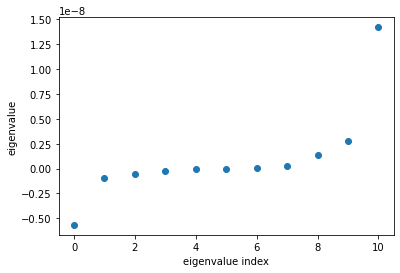

In [21]:
evals, _ = jnp.linalg.eigh(Y)
print(len(evals))
plt.scatter(np.arange(len(evals)), evals)
plt.xlabel('eigenvalue index')
plt.ylabel('eigenvalue')

In [22]:
new_w_layer2 = np.append(np.append(weights[110 : 110 + idx_neuron * 10],
                                   np.append(
                                       weights[110 + idx_neuron * 10 : 110 + (idx_neuron + 1) * 10],
                                       weights[110 + idx_neuron * 10 : 110 + (idx_neuron + 1) * 10])),
                         weights[110 + (idx_neuron + 1) * 10 : 210]).reshape(H_student + 1, H_student)
new_b_layer2 = np.append(np.append(weights[210 : 210 + idx_neuron],
                                   np.append([weights[210 + idx_neuron]],
                                            [weights[210 + idx_neuron]])),
                         weights[210 + idx_neuron + 1 : 220]).reshape(H_student + 1)

new_w_layer3 = np.array([*weights[220 : 220 + idx_neuron], *[0 * weights[220 + idx_neuron]], *[1 * weights[220 + idx_neuron]], *weights[220 + idx_neuron + 1 : 230],
               *weights[230 : 230 + idx_neuron], *[0 * weights[230 + idx_neuron]], *[1 * weights[230 + idx_neuron]], *weights[230 + idx_neuron + 1 : 240],
*weights[240 : 240 + idx_neuron], *[0 * weights[240 + idx_neuron]], *[1 * weights[240 + idx_neuron]], *weights[240 + idx_neuron + 1 : 250],
*weights[250 : 250 + idx_neuron], *[0 * weights[250 + idx_neuron]], *[1 * weights[250 + idx_neuron]], *weights[250 + idx_neuron + 1 : 260],
*weights[260 : 260 + idx_neuron], *[0 * weights[260 + idx_neuron]], *[1 * weights[260 + idx_neuron]], *weights[260 + idx_neuron + 1: 270],
*weights[270 : 270 + idx_neuron], *[0 * weights[270 + idx_neuron]], *[1 * weights[270 + idx_neuron]], *weights[270 + idx_neuron + 1: 280],
*weights[280 : 280 + idx_neuron], *[0 * weights[280 + idx_neuron]], *[1 * weights[280 + idx_neuron]], *weights[280 + idx_neuron + 1: 290],
*weights[290 : 290 + idx_neuron], *[0 * weights[290 + idx_neuron]], *[1 * weights[290 + idx_neuron]], *weights[290 + idx_neuron + 1: 300],
*weights[300 : 300 + idx_neuron], *[0 * weights[300 + idx_neuron]], *[1 * weights[300 + idx_neuron]], *weights[300 + idx_neuron + 1: 310],
*weights[310 : 310 + idx_neuron], *[0 * weights[310 + idx_neuron]], *[1 * weights[310 + idx_neuron]], *weights[310 + idx_neuron + 1: 320]])

new_w_layer3 = new_w_layer3.reshape(H_student, H_student + 1)

new_b_layer3 = np.append(np.append(weights[320 : 320 + idx_neuron],
                                   [weights[320 + idx_neuron]]),
                         weights[320 + idx_neuron + 1 : 330]).reshape(H_student)
new_w_out = np.append(np.append(weights[330: 330 + idx_neuron],
                                [weights[330 + idx_neuron]]),
                      weights[330 + idx_neuron + 1 : 340]).reshape(H_student, D_out)

In [23]:
new_weights = []
new_weights = np.append(new_weights, weights[0 : 100])
new_weights = np.append(new_weights, weights[100 : 110])

# new_weights = np.append(new_weights, weights[110 : 210])
# new_weights = np.append(new_weights, weights[210 : 220])

new_weights = np.append(new_weights, new_w_layer2)
new_weights = np.append(new_weights, new_b_layer2)

new_weights = np.append(new_weights, new_w_layer3)
new_weights = np.append(new_weights, new_b_layer3)

new_weights = np.append(new_weights, new_w_out)
new_weights = np.append(new_weights, [weights[340]])

In [24]:
print(jax_loss_second_layer(new_weights))

H = hessian(jax_loss_second_layer)(new_weights)
H = (H + H.T) / 2.0

evals, _ = jnp.linalg.eigh(H)
cnt = 0

for eval in evals:
    if abs(eval) <= 1e-9:
        cnt += 1

print(cnt)

0.1026920579402964
4


In [25]:
class DummyNetwork(nn.Module):
  def __init__(self, D_in, H, D_out,
               w_layer1, b_layer1,
               w_layer2, b_layer2,
               w_layer3, b_layer3,
               w_out, b_out):
    super(DummyNetwork, self).__init__()
    self.linear1 = nn.Linear(D_in, H, bias=True).double()
    self.linear2 = nn.Linear(H, H, bias=True).double()
    self.linear3 = nn.Linear(H, H + 1, bias=True).double()
    self.linear4 = nn.Linear(H + 1, D_out, bias=True).double()
    
    self.linear1.weight = torch.nn.Parameter(w_layer1)
    self.linear2.weight = torch.nn.Parameter(w_layer2)
    self.linear3.weight = torch.nn.Parameter(w_layer3)
    self.linear4.weight = torch.nn.Parameter(w_out)
    
    self.linear1.bias = torch.nn.Parameter(b_layer1)
    self.linear2.bias = torch.nn.Parameter(b_layer2)
    self.linear3.bias = torch.nn.Parameter(b_layer3)
    self.linear4.bias = torch.nn.Parameter(b_out)

  def forward(self, x):
    h1 = torch.sigmoid(self.linear1(x))
    h2 = torch.sigmoid(self.linear2(h1))
    h3 = torch.sigmoid(self.linear3(h2))
    y_pred = self.linear4(h3)
    return y_pred

In [26]:
dummy_network = DummyNetwork(D_in, H_student, D_out, torch.DoubleTensor(w_layer1), torch.DoubleTensor(b_layer1),
                            torch.DoubleTensor(w_layer2), torch.DoubleTensor(b_layer2),
                            torch.DoubleTensor(new_w_layer3), torch.DoubleTensor(new_b_layer3),
                            torch.DoubleTensor(new_w_out.T), torch.DoubleTensor([b_out]).reshape(1, 1))
dummy_network = dummy_network.to(device)
if device == 'cuda':
    dummy_network = torch.nn.DataParallel(dummy_network)

In [27]:
def train(model, x, y_labels, N = 2 * (10 ** 4), Ninner = 10 ** 3, Nstart = 10,
          maxtime = 7, nlopt_threshold = 1e-7,
          collect_history = True):
  lr = 1e-4
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

#   checkpoint = torch.load("local_min_model.pt")
#   model.load_state_dict(checkpoint['model_state_dict'])
  # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

  # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)


  loss_fn = nn.MSELoss()
  loss_vals = []
  trace = []
  if collect_history:
    trace.append((deepcopy(model.module.linear1.weight.cpu().data.detach().numpy()),
                  deepcopy(model.module.linear2.weight.cpu().data.detach().numpy()),
                  deepcopy(model.module.linear3.weight.cpu().data.detach().numpy()),
                  deepcopy(model.module.linear4.weight.cpu().data.detach().numpy())))
  for i in range(1, N + 1):
#     if i % 2 == 0:
#       optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
#     elif i % 2 == 1:
#       optimizer = torch.optim.SGD(model.parameters(), lr=1e-5)
#     else:
#       optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
    loss_tmp = []
    for j in range(1, Ninner + 1):
      y = model(x)
      loss = loss_fn(y, y_labels)
      loss_grad = torch.autograd.grad(loss, model.parameters(),
                                      retain_graph=True)
      grad_norm = eval_grad_norm(loss_grad)
      if grad_norm <= 1e-5 and i > 1:
#         print('found it')
#         return loss_vals, trace
        trace = []
        trace.append((deepcopy(model.module.linear1.weight.cpu().data.detach().numpy()),
              deepcopy(model.module.linear1.bias.cpu().data.detach().numpy()),
              deepcopy(model.module.linear2.weight.cpu().data.detach().numpy()),
              deepcopy(model.module.linear2.bias.cpu().data.detach().numpy()),
              deepcopy(model.module.linear3.weight.cpu().data.detach().numpy()),
              deepcopy(model.module.linear3.bias.cpu().data.detach().numpy()),
              deepcopy(model.module.linear4.weight.cpu().data.detach().numpy()),
              deepcopy(model.module.linear4.bias.cpu().data.detach().numpy())))

        new_weights_end = np.append(
            np.append(
                np.append(trace[-1][0].reshape(H_student * D_in),
                          trace[-1][1].reshape(H_student)),
                np.append(
                    np.append(trace[-1][2].reshape(H_student * D_in), 
                              trace[-1][3].reshape(H_student)),
                    np.append(trace[-1][4].reshape((H_student + 1) * D_in), 
                              trace[-1][5].reshape(H_student + 1)))),
            np.append(trace[-1][6][0],
                      trace[-1][7][0]))
        
        H = hessian(jax_loss)(new_weights_end)
        H = (H + H.T) / 2.0
        evals, _ = jnp.linalg.eigh(H)
#         print(evals)
        
        proper_local_min = True
        
        for eval in evals:
          if eval <= -1e-9:
            proper_local_min = False
            break
                
        if proper_local_min:
          print('found it' + str(j))
          EPOCH = 0
          PATH = "local_min_model.pt"
          LOSS = 0.4

          torch.save({
                    'epoch': EPOCH,
                    'model_state_dict': student_model.state_dict(),
                    'loss': LOSS,
                    }, PATH)
          return loss_vals, trace
      loss_tmp.append(loss.item())
      optimizer.zero_grad()
      loss.backward(retain_graph=True)
      optimizer.step()
      if i == 1 and (j % Nstart == 0) and j < Ninner:
        loss_vals.append(np.mean(loss_tmp[j - Nstart  : j]))
        if collect_history:
          trace.append((deepcopy(model.module.linear1.weight.cpu().data.detach().numpy()),
                      deepcopy(model.module.linear2.weight.cpu().data.detach().numpy()),
                      deepcopy(model.module.linear3.weight.cpu().data.detach().numpy()),
                      deepcopy(model.module.linear4.weight.cpu().data.detach().numpy())))
    loss_vals.append(np.mean(loss_tmp))
    if collect_history:
      trace.append((deepcopy(model.module.linear1.weight.cpu().data.detach().numpy()),
                  deepcopy(model.module.linear2.weight.cpu().data.detach().numpy()),
                  deepcopy(model.module.linear3.weight.cpu().data.detach().numpy()),
                  deepcopy(model.module.linear4.weight.cpu().data.detach().numpy())))
    grad_norm = eval_grad_norm(loss_grad)
    print("Iteration: %d, loss: %s, gradient norm: %s" % (Ninner * i,
                                                          np.mean(loss_tmp),
                                                          grad_norm))

#   EPOCH = i
#   PATH = "model.pt"
#   LOSS = 0.4

#   torch.save({
#             'epoch': EPOCH,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': LOSS,
#             }, PATH)
  return loss_vals, trace

# Plot the 12 smallest eigenvaleus

In [28]:
num_evals = 12

In [29]:
evals_mu = [[] for i in range(num_evals)]

for mu in np.arange(-1, 2, 0.1):
    new_w_layer2 = np.append(np.append(weights[110 : 110 + idx_neuron * 10],
                                       np.append(
                                           weights[110 + idx_neuron * 10 : 110 + (idx_neuron + 1) * 10],
                                           weights[110 + idx_neuron * 10 : 110 + (idx_neuron + 1) * 10])),
                             weights[110 + (idx_neuron + 1) * 10 : 210]).reshape(H_student + 1, H_student)
    new_b_layer2 = np.append(np.append(weights[210 : 210 + idx_neuron],
                                       np.append([weights[210 + idx_neuron]],
                                                [weights[210 + idx_neuron]])),
                             weights[210 + idx_neuron + 1 : 220]).reshape(H_student + 1)

    new_w_layer3 = np.array([*weights[220 : 220 + idx_neuron], *[mu * weights[220 + idx_neuron]], *[(1 - mu) * weights[220 + idx_neuron]], *weights[220 + idx_neuron + 1 : 230],
                   *weights[230 : 230 + idx_neuron], *[mu * weights[230 + idx_neuron]], *[(1 - mu) * weights[230 + idx_neuron]], *weights[230 + idx_neuron + 1 : 240],
    *weights[240 : 240 + idx_neuron], *[mu * weights[240 + idx_neuron]], *[(1 - mu) * weights[240 + idx_neuron]], *weights[240 + idx_neuron + 1 : 250],
    *weights[250 : 250 + idx_neuron], *[mu * weights[250 + idx_neuron]], *[(1 - mu) * weights[250 + idx_neuron]], *weights[250 + idx_neuron + 1 : 260],
    *weights[260 : 260 + idx_neuron], *[mu * weights[260 + idx_neuron]], *[(1 - mu) * weights[260 + idx_neuron]], *weights[260 + idx_neuron + 1: 270],
    *weights[270 : 270 + idx_neuron], *[mu * weights[270 + idx_neuron]], *[(1 - mu) * weights[270 + idx_neuron]], *weights[270 + idx_neuron + 1: 280],
    *weights[280 : 280 + idx_neuron], *[mu * weights[280 + idx_neuron]], *[(1 - mu) * weights[280 + idx_neuron]], *weights[280 + idx_neuron + 1: 290],
    *weights[290 : 290 + idx_neuron], *[mu * weights[290 + idx_neuron]], *[(1 - mu) * weights[290 + idx_neuron]], *weights[290 + idx_neuron + 1: 300],
    *weights[300 : 300 + idx_neuron], *[mu * weights[300 + idx_neuron]], *[(1 - mu) * weights[300 + idx_neuron]], *weights[300 + idx_neuron + 1: 310],
    *weights[310 : 310 + idx_neuron], *[mu * weights[310 + idx_neuron]], *[(1 - mu) * weights[310 + idx_neuron]], *weights[310 + idx_neuron + 1: 320]])

    new_w_layer3 = new_w_layer3.reshape(H_student, H_student + 1)

    new_b_layer3 = np.append(np.append(weights[320 : 320 + idx_neuron],
                                       [weights[320 + idx_neuron]]),
                             weights[320 + idx_neuron + 1 : 330]).reshape(H_student)
    new_w_out = np.append(np.append(weights[330: 330 + idx_neuron],
                                    [weights[330 + idx_neuron]]),
                          weights[330 + idx_neuron + 1 : 340]).reshape(H_student, D_out)
    
#     new_w_layer3 = np.append(np.append(weights[220 : 220 + idx_neuron * 10],
#                                        np.append(
#                                            weights[220 + idx_neuron * 10 : 220 + (idx_neuron + 1) * 10],
#                                            weights[220 + idx_neuron * 10 : 220 + (idx_neuron + 1) * 10])),
#                              weights[220 + (idx_neuron + 1) * 10 : 320]).reshape(H_student + 1, H_student)
#     new_b_layer3 = np.append(np.append(weights[320 : 320 + idx_neuron],
#                                        np.append([weights[320 + idx_neuron]],
#                                                 [weights[320 + idx_neuron]])),
#                              weights[320 + idx_neuron + 1 : 330]).reshape(H_student + 1)
#     new_w_out = np.append(np.append(weights[330: 330 + idx_neuron],
#                                     np.append([mu * weights[330 + idx_neuron]],
#                                               [(1 - mu) * weights[330 + idx_neuron]])),
#                       weights[330 + idx_neuron + 1 : 340]).reshape(H_student + 1, D_out)    
    
    
    new_weights = []
    new_weights = np.append(new_weights, weights[0 : 100])
    new_weights = np.append(new_weights, weights[100 : 110])

#     new_weights = np.append(new_weights, weights[110 : 210])
#     new_weights = np.append(new_weights, weights[210 : 220])

    new_weights = np.append(new_weights, new_w_layer2)
    new_weights = np.append(new_weights, new_b_layer2)

    new_weights = np.append(new_weights, new_w_layer3)
    new_weights = np.append(new_weights, new_b_layer3)

    new_weights = np.append(new_weights, new_w_out)
    new_weights = np.append(new_weights, [weights[340]])
    
    H = hessian(jax_loss_second_layer)(new_weights)
    H = (H + H.T) / 2.0
    
    evals, _ = jnp.linalg.eigh(H)
    for i in range(num_evals):
        evals_mu[i].append(evals[i])

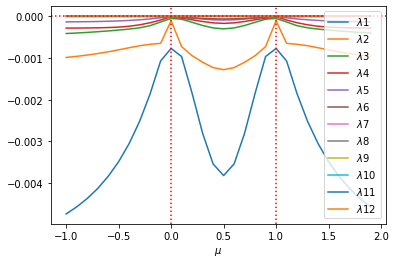

In [30]:
for i in range(num_evals):
    plt.plot(np.arange(-1, 2, 0.1), evals_mu[i], label=r'$\lambda$' + str(i + 1))
plt.xlabel(r'$\mu$')
plt.legend(loc="upper right")

plt.axhline(y = 0, color = 'r', linestyle = 'dotted')
plt.axvline(x = 0, color = 'r', linestyle = 'dotted')
plt.axvline(x = 1, color = 'r', linestyle = 'dotted')

plt.show()

In [ ]:
mus = []
losses = []
for mu in np.arange(-3, 4, 0.1):
    print('mu:', mu)
    new_w_layer3 = np.append(weights[220 : 230], weights[220 : 320]).reshape(H_student + 1, H_student)
    new_b_layer3 = np.append([weights[320]], weights[320 : 330]).reshape(H_student + 1)
    new_w_out = np.append([mu * weights[330], (1 - mu) * weights[330]], weights[331 : 340]).reshape(H_student + 1, D_out)
    
    mu, sigma = 0, 0.0001 # mean and standard deviation
    perturbation = np.random.normal(mu, sigma, len(new_weights))
    
    perturbed_w_layer1 = w_layer1 + perturbation[0 : w_layer1.size].reshape(D_in, H_student)
    offset = len(w_layer1)
    
    perturbed_b_layer1 = b_layer1 + perturbation[offset : offset + len(b_layer1)].reshape(H_student)
    offset += len(b_layer1)
    
    perturbed_w_layer2 = w_layer2 + perturbation[offset : offset + w_layer2.size].reshape(H_student, H_student)
    offset += len(w_layer2)
    
    perturbed_b_layer2 = b_layer2 + perturbation[offset : offset + len(b_layer2)].reshape(H_student)
    offset += len(b_layer2)
    
    pertured_w_layer3 = new_w_layer3 + perturbation[offset : offset + new_w_layer3.size].reshape(H_student + 1, H_student)
    offset += len(new_w_layer3)
    
    perturbed_b_layer3 = new_b_layer3 + perturbation[offset : offset + len(new_b_layer3)].reshape(H_student + 1)
    offset += len(new_b_layer3)
    
    
    perturbed_w_out = new_w_out + perturbation[offset : offset + new_w_out.size].reshape(H_student + 1, D_out)


    offset += len(new_w_out)
    
    perturbed_b_out = b_out + perturbation[offset : offset + 1]
    
    dummy_network = DummyNetwork(D_in, H_student, D_out,
                                 torch.DoubleTensor(perturbed_w_layer1), torch.DoubleTensor(perturbed_b_layer1),
                                 torch.DoubleTensor(perturbed_w_layer2), torch.DoubleTensor(perturbed_b_layer2),
                                 torch.DoubleTensor(pertured_w_layer3), torch.DoubleTensor(perturbed_b_layer3),
                                 torch.DoubleTensor(perturbed_w_out.T), torch.DoubleTensor([perturbed_b_out]))
    dummy_network = dummy_network.to(device)
    if device == 'cuda':
        dummy_network = torch.nn.DataParallel(dummy_network)
    
    loss_vals, trace = train(dummy_network,
                              torch_dataset_inputs,
                              torch_dataset_labels)
    plt.plot(loss_vals)
    break
    
    trace = []
    trace.append((deepcopy(dummy_network.module.linear1.weight.cpu().data.detach().numpy()),
                  deepcopy(dummy_network.module.linear1.bias.cpu().data.detach().numpy()),
                  deepcopy(dummy_network.module.linear2.weight.cpu().data.detach().numpy()),
                  deepcopy(dummy_network.module.linear2.bias.cpu().data.detach().numpy()),
                  deepcopy(dummy_network.module.linear3.weight.cpu().data.detach().numpy()),
                  deepcopy(dummy_network.module.linear3.bias.cpu().data.detach().numpy()),
                  deepcopy(dummy_network.module.linear4.weight.cpu().data.detach().numpy()),
                  deepcopy(dummy_network.module.linear4.bias.cpu().data.detach().numpy())))

    new_weights_end = np.append(
        np.append(
            np.append(trace[-1][0].reshape(H_student * D_in),
                      trace[-1][1].reshape(H_student)),
            np.append(
                np.append(trace[-1][2].reshape(H_student * D_in), 
                      trace[-1][3].reshape(H_student)),
                np.append(trace[-1][4].reshape((H_student + 1) * D_in), 
                      trace[-1][5].reshape(H_student + 1)))),
        np.append(trace[-1][6][0],
                  trace[-1][7][0]))


    
    mus.append(mu)
    losses.append(jax_loss(new_weights_end))

In [ ]:
trace = []
trace.append((deepcopy(dummy_network.module.linear1.weight.cpu().data.detach().numpy()),
              deepcopy(dummy_network.module.linear1.bias.cpu().data.detach().numpy()),
              deepcopy(dummy_network.module.linear2.weight.cpu().data.detach().numpy()),
              deepcopy(dummy_network.module.linear2.bias.cpu().data.detach().numpy()),
              deepcopy(dummy_network.module.linear3.weight.cpu().data.detach().numpy()),
              deepcopy(dummy_network.module.linear3.bias.cpu().data.detach().numpy()),
              deepcopy(dummy_network.module.linear4.weight.cpu().data.detach().numpy()),
              deepcopy(dummy_network.module.linear4.bias.cpu().data.detach().numpy())))

new_weights_end = np.append(
    np.append(
        np.append(trace[-1][0].reshape(H_student * D_in),
                  trace[-1][1].reshape(H_student)),
        np.append(
            np.append(trace[-1][2].reshape(H_student * D_in), 
                  trace[-1][3].reshape(H_student)),
            np.append(trace[-1][4].reshape((H_student + 1) * D_in), 
                  trace[-1][5].reshape(H_student + 1)))),
    np.append(trace[-1][6][0],
              trace[-1][7][0]))
print(jax_loss(new_weights_end), jnp.linalg.norm(jax_grad(jax_loss)(new_weights_end)))

In [ ]:
H = hessian(jax_loss)(new_weights_end)
H = (H + H.T) / 2.0
evals, _ = jnp.linalg.eigh(H)
print(evals[:10])
print(jnp.linalg.norm(new_weights_end - new_weights))

In [ ]:
_, _ = train(dummy_network, torch_dataset_inputs, torch_dataset_labels)

Iteration: 1000, loss: 0.10270604704257065, gradient norm: 0.011078588217699798
Iteration: 2000, loss: 0.10269743060484009, gradient norm: 0.2875029134228121
Iteration: 3000, loss: 0.10269770154291535, gradient norm: 0.7109272681656998
Iteration: 4000, loss: 0.1026978519181091, gradient norm: 0.3418418293695122
Iteration: 5000, loss: 0.10269775888767396, gradient norm: 0.36774263792057
Iteration: 6000, loss: 0.10269744748612614, gradient norm: 0.6632348194846205
Iteration: 7000, loss: 0.10269732537999365, gradient norm: 0.5554117927262803
Iteration: 8000, loss: 0.10269685543982726, gradient norm: 0.510397573260132
Iteration: 9000, loss: 0.10269578054651307, gradient norm: 1.1030923270214137
Iteration: 10000, loss: 0.10269431888365248, gradient norm: 1.1670429564198743
Iteration: 11000, loss: 0.10269216896995641, gradient norm: 0.14696966531964778
Iteration: 12000, loss: 0.10268967014738001, gradient norm: 0.41511374564268033
Iteration: 13000, loss: 0.10268688178360404, gradient norm: 1

In [ ]:
final_weights = second_order_opt(final_weights, 10000)

In [ ]:
print(jax_loss(final_weights), jnp.linalg.norm(jax_grad(jax_loss)(final_weights)))

In [ ]:
H = hessian(jax_loss)(new_weights_end)
H = (H + H.T) / 2.0
evals, _ = jnp.linalg.eigh(H)
print(evals[:10])

In [44]:
trace = []
trace.append((deepcopy(dummy_network.module.linear1.weight.cpu().data.detach().numpy()),
              deepcopy(dummy_network.module.linear1.bias.cpu().data.detach().numpy()),
              deepcopy(dummy_network.module.linear2.weight.cpu().data.detach().numpy()),
              deepcopy(dummy_network.module.linear2.bias.cpu().data.detach().numpy()),
              deepcopy(dummy_network.module.linear3.weight.cpu().data.detach().numpy()),
              deepcopy(dummy_network.module.linear3.bias.cpu().data.detach().numpy()),
              deepcopy(dummy_network.module.linear4.weight.cpu().data.detach().numpy()),
              deepcopy(dummy_network.module.linear4.bias.cpu().data.detach().numpy())))

new_weights_end = np.append(
    np.append(
        np.append(trace[-1][0].reshape(H_student * D_in),
                  trace[-1][1].reshape(H_student)),
        np.append(
            np.append(trace[-1][2].reshape(H_student * D_in), 
                  trace[-1][3].reshape(H_student)),
            np.append(trace[-1][4].reshape((H_student + 1) * D_in), 
                  trace[-1][5].reshape(H_student + 1)))),
    np.append(trace[-1][6][0],
              trace[-1][7][0]))

print(jax_loss(weights), jax_loss(new_weights_end))
print(jnp.linalg.norm(jax_grad(jax_loss)(weights)), jnp.linalg.norm(jax_grad(jax_loss)(new_weights_end)))
print(np.linalg.norm(new_weights_end - new_weights))

0.1026920579402963 0.10144003755288118
9.95016526425352e-06 0.07283338667347572
13.566518233982933


In [ ]:
H = hessian(jax_loss)(new_weights_end)
H = (H + H.T) / 2.0
evals, _ = jnp.linalg.eigh(H)
print(evals[:10])

In [ ]:
EPOCH = 0
PATH = "local_min_model.pt"
LOSS = 0.4
torch.save({
            'epoch': EPOCH,
            'model_state_dict': dummy_network.state_dict(),
            'loss': LOSS,
            }, PATH)